# Data

In [1]:
import pandas as pd
import numpy as np
import time
from collections import defaultdict
from tqdm.notebook import tqdm
import cv2
from functools import partial
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import metrics as mt
from torch.utils.data.sampler import SubsetRandomSampler

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
TRAIN_DIR = '/kaggle/input/rsna-icdataset/RSNA_ICDataset'

In [3]:
def get_train_dir(row:pd.DataFrame):
    return f"{TRAIN_DIR}/images/{row['patient_id']}_{row['series_id']}_{row['instance_number']}.png"

In [4]:
image_meta = pd.read_pickle(f'{TRAIN_DIR }/meta.pkl').drop_duplicates()
image_meta.head()

,dcm_path,png_path,identifier,patient_id,series_id,instance_number,injury_name,Active_Extravasation,Bowel
0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,/kaggle/working/RSNA_ICDataset/images/33_55570...,33_55570_93,33,55570,93,Bowel,0,1
1,/kaggle/input/rsna-2023-abdominal-trauma-detec...,/kaggle/working/RSNA_ICDataset/images/33_55570...,33_55570_94,33,55570,94,Bowel,0,1
2,/kaggle/input/rsna-2023-abdominal-trauma-detec...,/kaggle/working/RSNA_ICDataset/images/33_55570...,33_55570_95,33,55570,95,Bowel,0,1
3,/kaggle/input/rsna-2023-abdominal-trauma-detec...,/kaggle/working/RSNA_ICDataset/images/33_55570...,33_55570_96,33,55570,96,Bowel,0,1
4,/kaggle/input/rsna-2023-abdominal-trauma-detec...,/kaggle/working/RSNA_ICDataset/images/33_55570...,33_55570_97,33,55570,97,Bowel,0,1


In [5]:
sick_meta = pd.read_pickle(f'{TRAIN_DIR}/sick_only.pkl')
print(len(sick_meta))

11536


In [6]:
h_ace = pd.read_pickle(TRAIN_DIR +'/healthy_ace.pkl')
print(len(h_ace))

6193


In [7]:
h_bowel = pd.read_pickle(TRAIN_DIR +'/healthy_bowel.pkl')
print(len(h_bowel))

5576


In [8]:
sick_ace = sick_meta[sick_meta['Active_Extravasation']==1]
unique_ace = sick_ace['series_id'].unique()
disp_s = sick_ace[sick_ace['series_id']==unique_ace[12]]

In [9]:
disp_s.head()

,dcm_path,patient_id,series_id,instance_number,injury_name,Active_Extravasation,Bowel
341,/kaggle/input/rsna-2023-abdominal-trauma-detec...,4093,8236,66,"Bowel, Active_Extravasation",1,1
342,/kaggle/input/rsna-2023-abdominal-trauma-detec...,4093,8236,67,"Bowel, Active_Extravasation",1,1
343,/kaggle/input/rsna-2023-abdominal-trauma-detec...,4093,8236,68,"Bowel, Active_Extravasation",1,1
344,/kaggle/input/rsna-2023-abdominal-trauma-detec...,4093,8236,69,"Bowel, Active_Extravasation",1,1
345,/kaggle/input/rsna-2023-abdominal-trauma-detec...,4093,8236,70,"Bowel, Active_Extravasation",1,1


In [10]:
def display(i, im):
    img = Image.open(get_train_dir(disp_s.iloc[i]))
    im.set_array(img)
    plt.title(str(disp_s.iloc[i]['series_id']) +" "+ str(disp_s.iloc[i]['instance_number']))

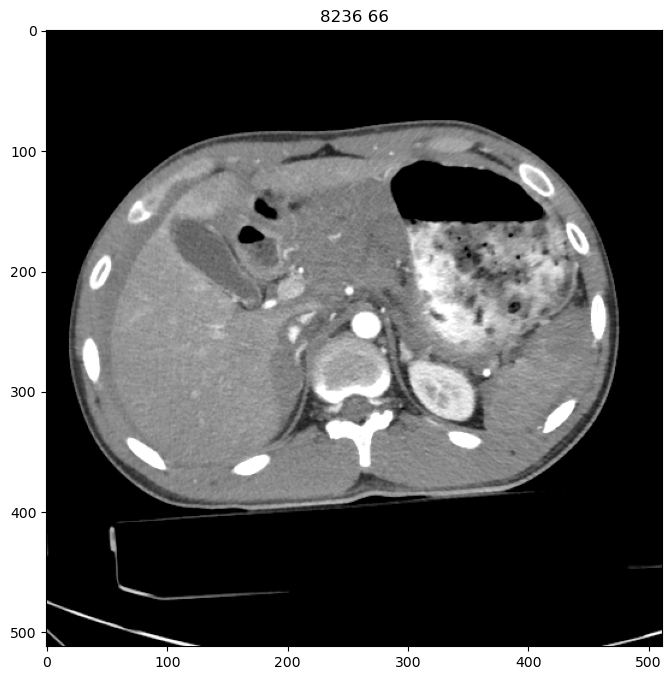

In [11]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(16, 8))

img = Image.open(get_train_dir(disp_s.iloc[0]))
im = ax.imshow(img, cmap='gray', vmin=0, vmax = 255, animated=True)

amn = animation.FuncAnimation(fig, lambda i : display(i, im), frames=range(len(disp_s)), repeat=True, repeat_delay=50000)

# Demonstrate the animation
HTML(amn.to_html5_video())

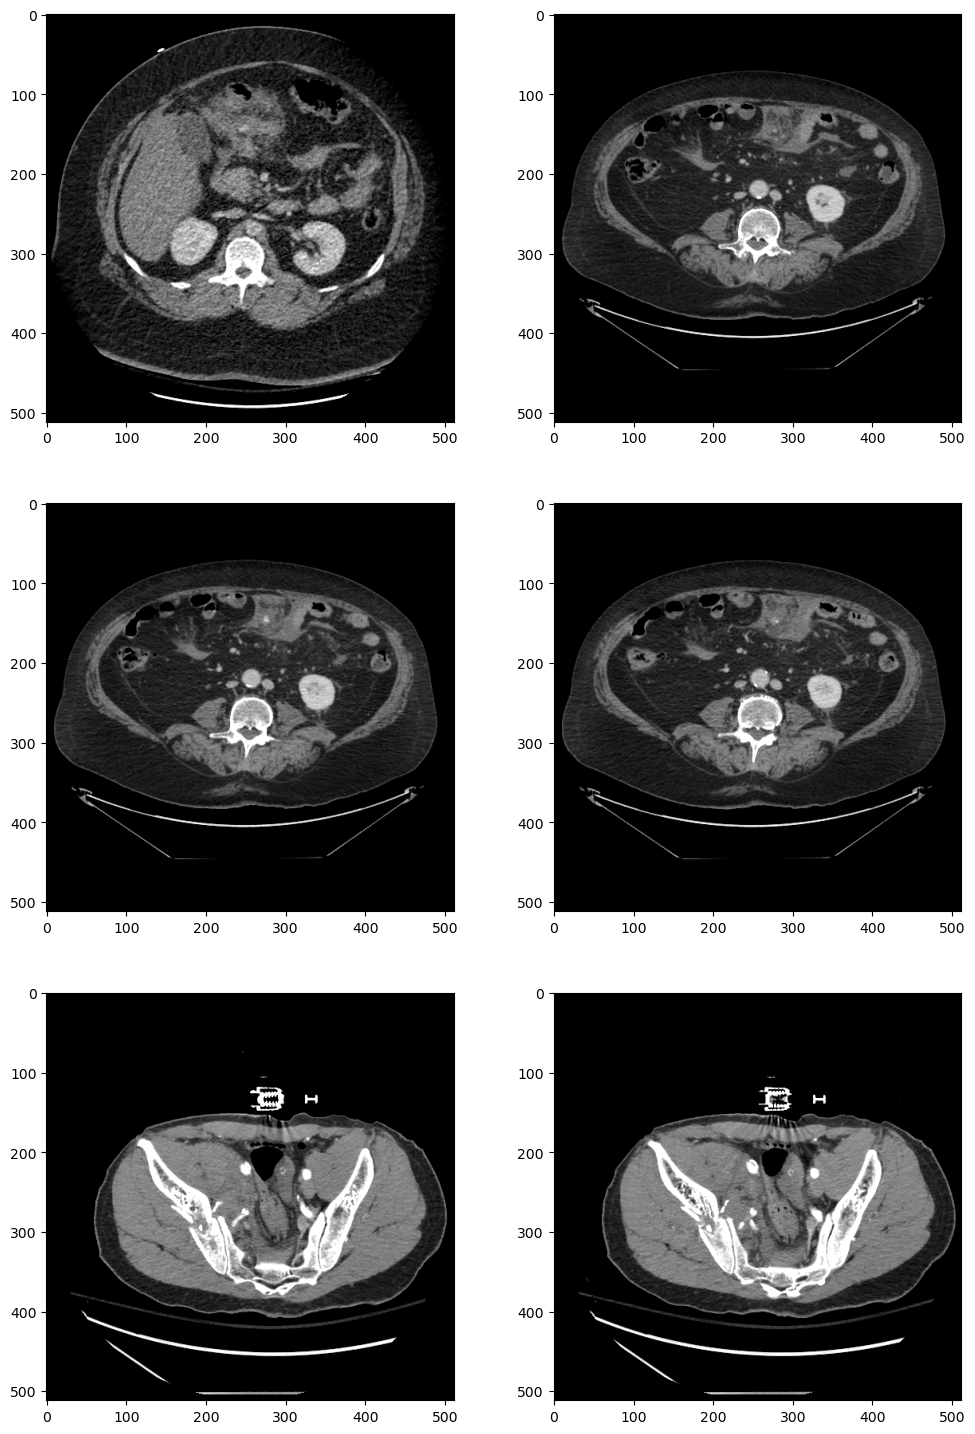

In [12]:
fig, axes = plt.subplots(3,2, figsize=(12,18))
ax = axes.ravel()
i = 0
for _, row in sick_ace.iterrows():
    img = Image.open(get_train_dir(row))
    ax[i].imshow(img, cmap = 'gray')
    i += 1
    if i == len(ax):
        break

In [13]:
import os
import glob
import torch
from PIL import Image, ImageDraw

class TDataset(torch.utils.data.Dataset):

    def __init__(self, healthy_AcE: pd.DataFrame, healthy_bowel:pd.DataFrame, 
                 sick_meta: pd.DataFrame, transform, load: str = 'cv2', 
                 norm:bool = True, labels='all', limit:int = None):

        self.transforms = transform
        self.load = load
        self.norm = norm
        self.labels = labels # ['ace', 'bowel', 'all']
        if labels == 'all':
            image_meta = pd.concat([sick_meta, healthy_AcE, healthy_bowel], axis=0).drop(['instances', 'instance_p'], axis = 1)
            image_meta = image_meta.drop_duplicates()
            image_meta = image_meta.sample(frac=1)
            self.image_paths = [f"{TRAIN_DIR}/images/{row['patient_id']}_{row['series_id']}_{row['instance_number']}.png" for ind, row in image_meta.iterrows()]
            self.bowel = np.array(image_meta['Bowel'])
            self.AcE = np.array(image_meta['Active_Extravasation'])
            if limit:
                self.image_paths = self.image_paths[0:limit]
                self.bowel = self.bowel[0:limit]
                self.AcE = self.AcE[0:limit]
        elif labels == 'ace':
            sick_meta = sick_meta[sick_meta['Active_Extravasation']==1]
            image_meta = pd.concat([sick_meta, healthy_AcE], axis=0).sample(frac=1).drop(['instances', 'instance_p'], axis = 1)
            self.image_paths = [f"{TRAIN_DIR}/images/{row['patient_id']}_{row['series_id']}_{row['instance_number']}.png" for ind, row in image_meta.iterrows()]
            self.AcE = np.array(image_meta['Active_Extravasation'])
            if limit:
                self.image_paths = self.image_paths[0:limit]
                self.AcE = self.AcE[0:limit]
        elif labels == 'bowel':
            sick_meta = sick_meta[sick_meta['Bowel']==1]
            image_meta = pd.concat([sick_meta, healthy_bowel], axis=0).sample(frac=1).drop(['instances', 'instance_p'], axis = 1)
            self.image_paths = [f"{TRAIN_DIR}/images/{row['patient_id']}_{row['series_id']}_{row['instance_number']}.png" for ind, row in image_meta.iterrows()]
            self.bowel = np.array(image_meta['Bowel'])  
            if limit:
                self.image_paths = self.image_paths[0:limit]
                self.bowel = self.bowel[0:limit]
                
    def _load_cv2(self, index):
        img = np.array(cv2.imread(self.image_paths[index]), dtype="float32")
        if self.norm:
            img = img/255.0
        return img
    
    def _load_pil(self, index):
        img = np.array(Image.open(self.image_paths[index]), dtype="float32")
        if self.norm:
            img = img/255.0
        return np.expand_dims(img, axis = 2)

    def __getitem__(self, index: int)->tuple[np.ndarray, np.ndarray]:
        if self.load=='cv2':
            img = self._load_cv2(index)
        elif self.load == 'PIL':
            img = self._load_pil(index)
            
        if self.transforms is not None:
            augmented = self.transforms(image=img)
            img = augmented['image']
         
        if self.labels == 'all':
            return img,torch.tensor([self.AcE[index], self.bowel[index]], dtype=torch.float32)
        elif self.labels == 'ace':
            return img,torch.tensor([self.AcE[index]], dtype=torch.float32)
        elif self.labels == 'bowel':
            return img,torch.tensor([self.bowel[index]], dtype=torch.float32)
    
    def __len__(self):
        return(len(self.image_paths))

In [15]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [16]:
train_transforms = A.Compose([
    A.augmentations.geometric.resize.Resize(224, 224),
    #A.HorizontalFlip(p=0.5),
    #A.VerticalFlip(p=0.5),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.augmentations.geometric.resize.Resize(224, 224),
    ToTensorV2()
])

In [20]:
image_meta = image_meta.sample(frac=1)
train, test = np.array_split(image_meta, 2)  

# Model

In [17]:
!pip install timm==0.6.11
!git clone https://github.com/sail-sg/metaformer.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.7/548.7 kB 14.4 MB/s eta 0:00:0000:01
  Attempting uninstall: timm
    Found existing installation: timm 0.9.2
    Uninstalling timm-0.9.2:
      Successfully uninstalled timm-0.9.2
Cloning into 'metaformer'...
remote: Enumerating objects: 205, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 205 (delta 146), reused 173 (delta 118), pack-reused 0
Receiving objects: 100% (205/205), 364.53 KiB | 12.15 MiB/s, done.
Resolving deltas: 100% (146/146), done.


In [18]:
import torch
import timm
import torch.nn as nn
from functools import partial
import torch.nn.functional as F
from metaformer import metaformer_baselines as mb

In [33]:
DOWNSAMPLE_LAYERS_FIVE_STAGES = [partial(mb.Downsampling,
            kernel_size=3, stride=2, padding=1,
            post_norm=partial(mb.LayerNormGeneral, bias=False, eps=1e-6)
            )] + \
            [partial(mb.Downsampling,
                kernel_size=7, stride=4, padding=2,
                pre_norm=partial(mb.LayerNormGeneral, bias=False, eps=1e-6), pre_permute=True
            )] + \
            [partial(mb.Downsampling,
                kernel_size=3, stride=2, padding=1, 
                pre_norm=partial(mb.LayerNormGeneral, bias=False, eps=1e-6), pre_permute=True
            )]*3

In [15]:
'''(self, in_chans=3, num_classes=1000, 
                 depths=[2, 2, 6, 2],
                 dims=[128, 256, 320, 512],
                 downsample_layers=DOWNSAMPLE_LAYERS_FOUR_STAGES,
                 mlps=Mlp,
                 norm_layers=partial(LayerNormWithoutBias, eps=1e-6), # partial(LayerNormGeneral, eps=1e-6, bias=False),
                 drop_path_rate=0.,
                 head_dropout=0.0, 
                 layer_scale_init_values=None,
                 res_scale_init_values=[None, None, 1.0, 1.0],
                 output_norm=partial(nn.LayerNorm, eps=1e-6), 
                 head_fn=nn.Linear,'''
 

'(self, in_chans=3, num_classes=1000, \n                 depths=[2, 2, 6, 2],\n                 dims=[128, 256, 320, 512],\n                 downsample_layers=DOWNSAMPLE_LAYERS_FOUR_STAGES,\n                 mlps=Mlp,\n                 norm_layers=partial(LayerNormWithoutBias, eps=1e-6), # partial(LayerNormGeneral, eps=1e-6, bias=False),\n                 drop_path_rate=0.,\n                 head_dropout=0.0, \n                 layer_scale_init_values=None,\n                 res_scale_init_values=[None, None, 1.0, 1.0],\n                 output_norm=partial(nn.LayerNorm, eps=1e-6), \n                 head_fn=nn.Linear,'

In [19]:
class MlpHead(nn.Module):
    """ MLP classification head
    """
    def __init__(self, dim, num_classes=1000, mlp_ratio=2, act_layer=mb.SquaredReLU,
        norm_layer=nn.LayerNorm, head_dropout=0., bias=True):
        super().__init__()
        hidden_features = int(mlp_ratio * dim)
        self.fc1 = nn.Linear(dim, hidden_features, bias=bias)
        self.act = act_layer()
        self.norm = norm_layer(hidden_features)
        self.fc2 = nn.Linear(hidden_features, num_classes, bias=bias)
        self.head_dropout = nn.Dropout(head_dropout)
        

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.norm(x)
        x = self.head_dropout(x)
        x = self.fc2(x)
        return x

In [38]:
# Multi-Head Multi-Class Classifier 
class MHMC_metaformer(nn.Module):
    def __init__(self, in_channels = 3, dims = [64, 128, 320, 512]):
        super().__init__()
        self.in_channels = in_channels
        self.dims = dims
        ###
        backbone = mb.caformer_s36_384(pretrained=True)
        self.downsamples = list(backbone.children())[0]
        self.metaformers = list(backbone.children())[1]
        self.norm = nn.LayerNorm(dims[-1], eps=1e-6)
        
        self.AcE_head = MlpHead(dim = dims[-1], num_classes = 2)
        #self.Bowel_head = MlpHead(dim = dims[-1], num_classes = 1)

    def forward(self, input):
        # Encoding
        x = input
        for i in range(len(self.dims)):
            x = self.metaformers[i](self.downsamples[i](x))
            
        x = self.norm(x.mean([1, 2]))
        
        AcE = self.AcE_head(x)
        #bowel = self.Bowel_head(x)
        #x = torch.cat([AcE, bowel], axis = 1)
        
        return AcE

In [36]:
# Single-Head Multi-Class Classifier 
class SHMC_metaformer(nn.Module):
    def __init__(self, in_channels = 1, dims = [32, 64, 128, 256, 512]):
        super().__init__()
        self.in_channels = in_channels
        self.dims = dims
        ###
        self.backbone = mb.MetaFormer(
                                in_chans = in_channels,
                                depths=[2, 2, 2, 3, 2],
                                dims=dims,
                                downsample_layers=DOWNSAMPLE_LAYERS_FIVE_STAGES,
                                token_mixers=[mb.Pooling, mb.SepConv, mb.SepConv, mb.Attention, mb.Attention],
                                res_scale_init_values=[1.0, 1.0, 1.0, 1.0, 1.0],
                                head_fn=nn.Identity)
        
        self.head = MlpHead(dim = dims[-1], num_classes = 1)

    def forward(self, input):
        # Encoding
        x = self.backbone(input)
        x = self.head(x)
        
        return x

# Training 
 testing the two types of models:  
 1. Single head clssification layer
 2. Multi head classification layer

In [ ]:
import wandb
from kaggle_secrets import UserSecretsClient
os.environ["WANDB_SILENT"] = "true"
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_api")
wandb.login(key=wandb_api)

In [42]:
MHMC_CONFIG = dict (
    num_labels = 2,
    img_width = 384,
    img_height = 384,
    batch_size = 6,
    epochs = 5,
    learning_rate = 0.014,
    architecture = "Metaformers",
    infra = "Kaggle",
    model_name = "MHMC"
)

SHMC_CONFIG = dict (
    num_labels = 2,
    img_width = 512,
    img_height = 512,
    batch_size = 6,
    epochs = 5,
    learning_rate = 0.01,
    architecture = "Metaformers",
    infra = "Kaggle",
    model_name = "SHMC"
)
CONFIG = [MHMC_CONFIG, SHMC_CONFIG]

In [20]:
def metrics_description(metrics:dict, epoch_samples: int, phase:str)->str:
    outputs = phase + ": ||"
    for k in metrics.keys():
        outputs += (" {}: {:4f} ||".format(k, np.sum(metrics[k]) / epoch_samples))
    return outputs

# Full training

In [43]:
def train(model:nn.Module, model_name:str,  healthy_ace:pd.DataFrame, healthy_bowel:pd.DataFrame, sick_meta:pd.DataFrame, 
          epochs:int=20, use_wandb:bool = True, wandb_config= None, parallel = False, labels='all', load_fn= "PIL"):
    try:
        gc.collect()
        torch.cuda.empty_cache()
    except:
        pass
    
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model()
    
    if parallel:
        model= nn.DataParallel(model).to(device)
    else: 
        model = model.to(device)
    
    epochs = epochs
    model_name = model_name

    ##############################################################################
                              ## set up loss and metric ##
    BCE = nn.BCEWithLogitsLoss(weight=None).to(device)#torch.tensor([1.70711297071, 2.1950617284], dtype=torch.float32)).to(device)
    
    best_loss = 1e10
    
    metric_list = {'train': [],
                   'val': [],
                   'samples': []}
    
    ##############################################################################
                              ## LOAD DATASETS ##
    # Creating data indices for training and validation splits:
    dataset = TDataset(healthy_ace, healthy_ace, sick_meta, train_transforms, labels = labels, limit = None, load = load_fn)
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_size = 0.15
    split = int(np.floor(val_size * dataset_size))
    np.random.shuffle(indices)
        
    train_indices, val_indices = indices[split:], indices[:split]
    
    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    
    labeled_loaders = {
        'train':  torch.utils.data.DataLoader(dataset, batch_size=wandb_config['batch_size'], sampler=train_sampler, num_workers = 2),
        'val': torch.utils.data.DataLoader(dataset, batch_size=wandb_config['batch_size'], sampler=val_sampler, num_workers = 2)
    }
    ##############################################################################
                          ## OPTIMIZER AND SHELDUER ##

    optimizer = torch.optim.Adam(model.parameters(), lr= wandb_config['learning_rate'])

    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e2,
     #                                       max_lr=1e-2, epochs=epochs, steps_per_epoch=len(labeled_loaders["train"]))
    

  #############################################################################
    print(" ____________________________________________________________")
    print("|                          Training                          |")
    print("|____________________________________________________________|")

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}: ")
        since = time.time()
        #Each epoch has a training and validation phase
        for phase in ['train','val']: #, 'val'
            if use_wandb:
                run = wandb.init(project='RSNA', 
                                 config=wandb_config,
                                 group='Metaformers', 
                                 job_type=phase,
                                 name = 'Epoch '+str(epoch)
                                 ) 

            print("Phase: "+ phase)
            # Set model to phase
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(list)
            epoch_samples = 0
            ace_gt = []
            ace_pred = []
            
            with tqdm(labeled_loaders[phase], unit = "batch",
                    total = len(labeled_loaders[phase])) as tepoch:
                for inputs, labels in labeled_loaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
  
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    # forward
                    with torch.set_grad_enabled(phase == 'train'):
                        preds = model(inputs)

                        pc = preds.clone()
                        pred = nn.Sigmoid()(pc)
                        loss =  BCE(preds, labels)
                        
                        if phase == 'val':
                            ace_gt.append(labels.clone().cpu().numpy())                      
                            ace_pred.append(pred.clone().cpu().numpy())
   
                    metrics['Loss'].append(loss.clone().detach().cpu().numpy())
                    
                        
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                       # scheduler.step()

                    epoch_samples += 1
                    tepoch.set_description(metrics_description(metrics,
                                                              epoch_samples,
                                                              phase))
                    tepoch.update(1)
            
            ep_metrics = {}
            for key, value in metrics.items():
                ep_metrics["Epoch "+key] = sum(value)/epoch_samples
                
            metric_list[phase].append(metrics)
            
            if phase == 'val':
                ace_gt = np.array(np.concatenate(ace_gt, axis = 0))
                ace_pred = np.array(np.concatenate(ace_pred, axis = 0).round())
                for i in range(ace_gt.shape[1]):
                    true = ace_gt[:,i]
                    pred = ace_pred[:,i]

                    confusion_matrix = mt.confusion_matrix(true, pred, labels=[0,1])
                    cm_display = mt.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

                    cm_display.plot()
                    plt.show() 
                #bowel_gt = np.concatenate(bowel_gt, axis = 0)
                #bowel_pred = np.concatenate(bowel_pred, axis = 0).round()
                
            if use_wandb:
                wandb.log(metrics)
                wandb.log(ep_metrics)

                run.finish()
                
            print(metrics_description(metrics, epoch_samples, phase))
            print("-----"*10)

                
        metric_list['samples'].append(epoch_samples)
        epoch_loss = sum(metrics['loss']) / epoch_samples
        
        if epoch_loss < best_loss:
            best_loss = epoch_loss

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print("#####"*10)

    print('Best validation loss: {:4f}'.format(best_loss))

    return model, metric_list

 ____________________________________________________________
|                          Training                          |
|____________________________________________________________|
Epoch 1/10: 
Phase: train


  0%|          | 0/2446 [00:00<?, ?batch/s]

train: || Loss: 0.664804 ||
--------------------------------------------------
Phase: val


  0%|          | 0/432 [00:00<?, ?batch/s]

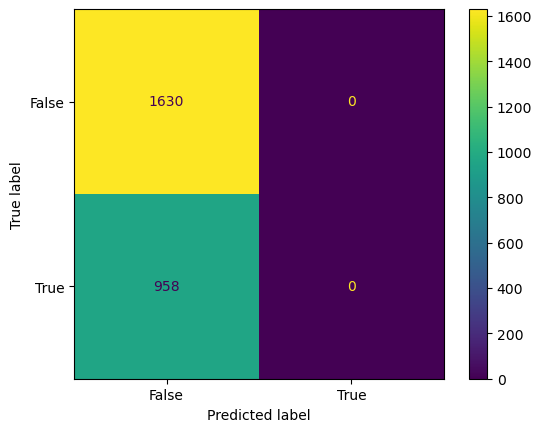

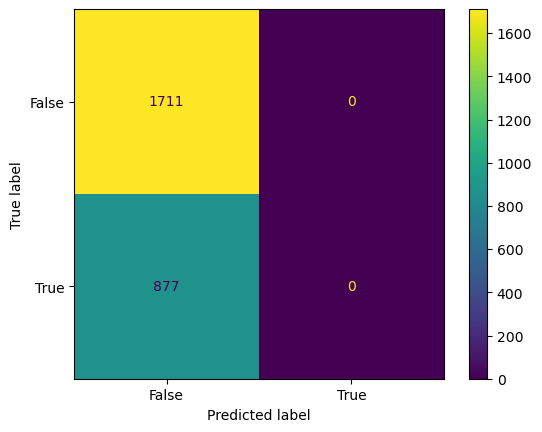

val: || Loss: 0.654890 ||
--------------------------------------------------
22m 54s
##################################################
Epoch 2/10: 
Phase: train


  0%|          | 0/2446 [00:00<?, ?batch/s]

train: || Loss: 0.653257 ||
--------------------------------------------------
Phase: val


  0%|          | 0/432 [00:00<?, ?batch/s]

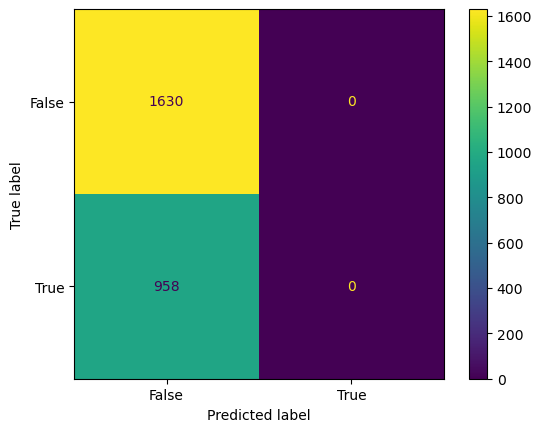

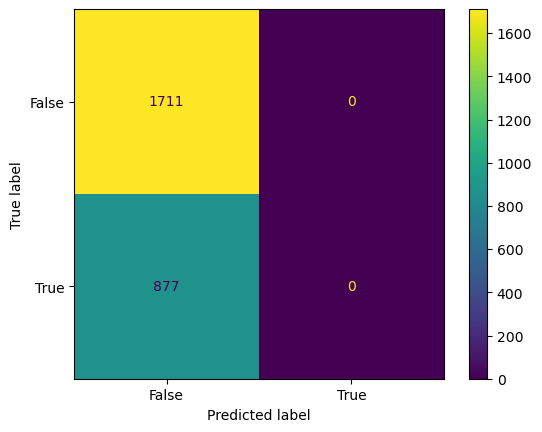

val: || Loss: 0.650048 ||
--------------------------------------------------
22m 50s
##################################################
Epoch 3/10: 
Phase: train


  0%|          | 0/2446 [00:00<?, ?batch/s]

In [ ]:
a = train(MHMC_metaformer, 'MHMC', h_ace, h_bowel, sick_meta, epochs = 10, use_wandb = False, wandb_config=MHMC_CONFIG, parallel = True, labels='all', load_fn = 'cv2')

 ____________________________________________________________
|                          Training                          |
|____________________________________________________________|
Epoch 1/10: 
Phase: train


  0%|          | 0/567 [00:00<?, ?batch/s]

train: || Loss: 0.924957 ||
--------------------------------------------------
Phase: val


  0%|          | 0/100 [00:00<?, ?batch/s]

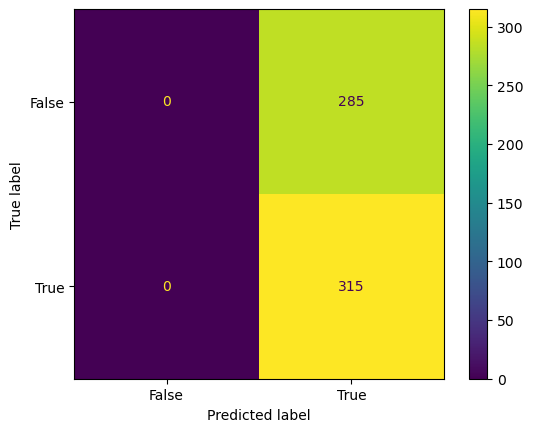

val: || Loss: 0.820242 ||
--------------------------------------------------
2m 4s
##################################################
Epoch 2/10: 
Phase: train


  0%|          | 0/567 [00:00<?, ?batch/s]

train: || Loss: 0.816826 ||
--------------------------------------------------
Phase: val


  0%|          | 0/100 [00:00<?, ?batch/s]

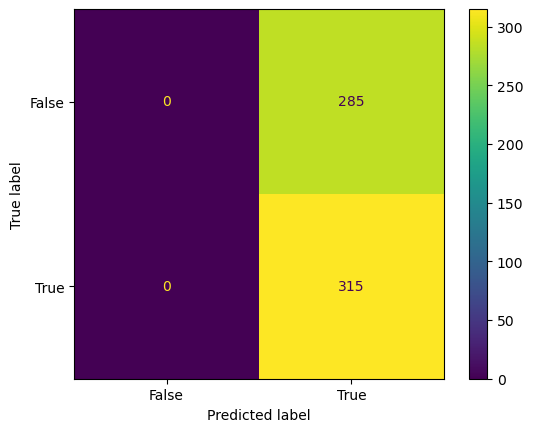

val: || Loss: 0.811317 ||
--------------------------------------------------
1m 48s
##################################################
Epoch 3/10: 
Phase: train


  0%|          | 0/567 [00:00<?, ?batch/s]

train: || Loss: 0.819006 ||
--------------------------------------------------
Phase: val


  0%|          | 0/100 [00:00<?, ?batch/s]

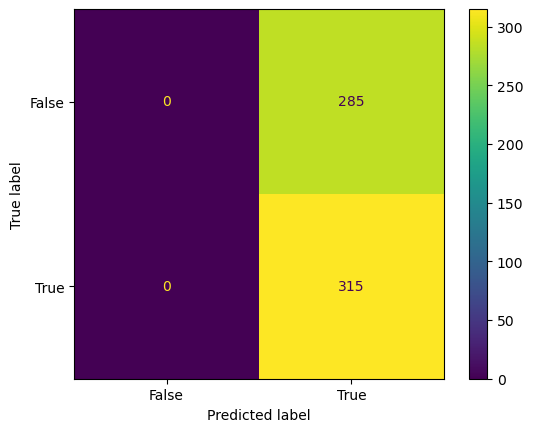

val: || Loss: 0.814792 ||
--------------------------------------------------
1m 48s
##################################################
Epoch 4/10: 
Phase: train


  0%|          | 0/567 [00:00<?, ?batch/s]

train: || Loss: 0.815226 ||
--------------------------------------------------
Phase: val


  0%|          | 0/100 [00:00<?, ?batch/s]

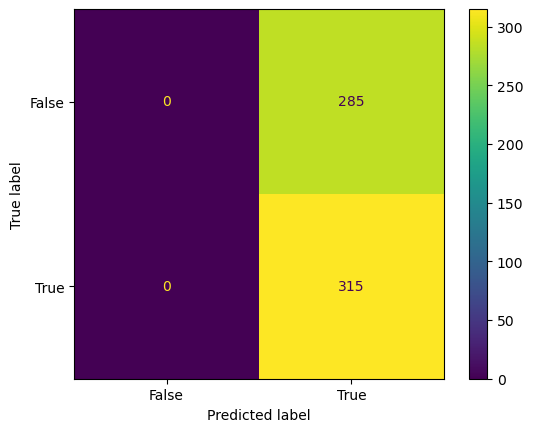

val: || Loss: 0.813790 ||
--------------------------------------------------
1m 49s
##################################################
Epoch 5/10: 
Phase: train


  0%|          | 0/567 [00:00<?, ?batch/s]

train: || Loss: 0.818464 ||
--------------------------------------------------
Phase: val


  0%|          | 0/100 [00:00<?, ?batch/s]

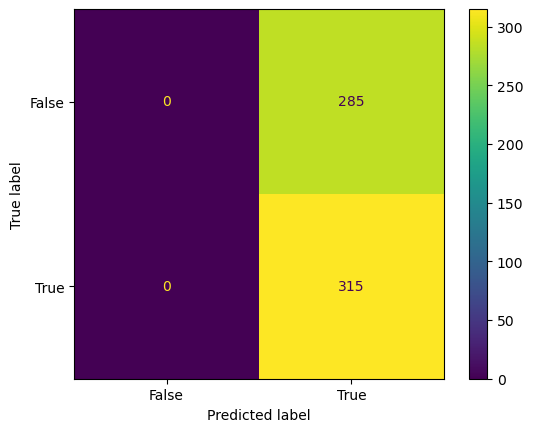

val: || Loss: 0.815326 ||
--------------------------------------------------
1m 48s
##################################################
Epoch 6/10: 
Phase: train


  0%|          | 0/567 [00:00<?, ?batch/s]

train: || Loss: 0.817202 ||
--------------------------------------------------
Phase: val


  0%|          | 0/100 [00:00<?, ?batch/s]

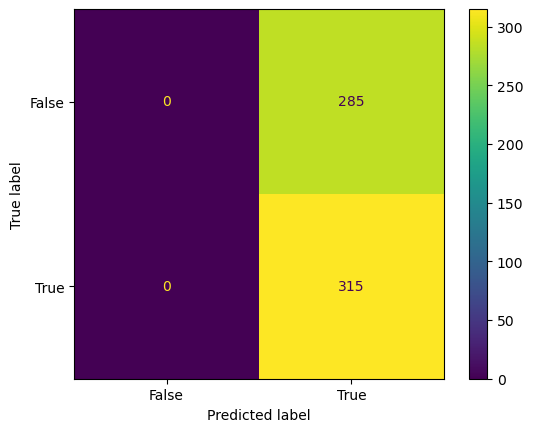

val: || Loss: 0.816535 ||
--------------------------------------------------
1m 48s
##################################################
Epoch 7/10: 
Phase: train


  0%|          | 0/567 [00:00<?, ?batch/s]

train: || Loss: 0.823271 ||
--------------------------------------------------
Phase: val


  0%|          | 0/100 [00:00<?, ?batch/s]

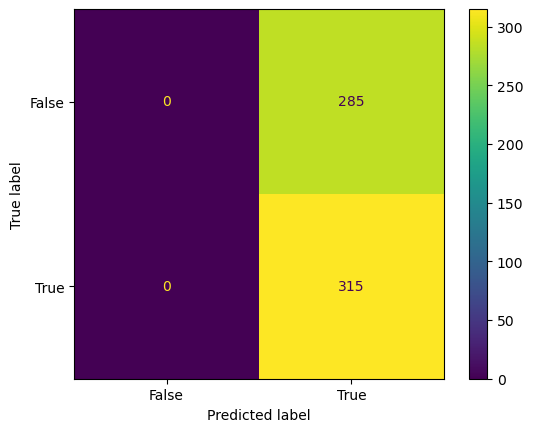

val: || Loss: 0.814218 ||
--------------------------------------------------
1m 48s
##################################################
Epoch 8/10: 
Phase: train


  0%|          | 0/567 [00:00<?, ?batch/s]

In [ ]:
a = train(SHMC_metaformer, 'SHMC', h_ace, h_bowel, sick_meta, epochs = 10, use_wandb = False, wandb_config=SHMC_CONFIG, parallel = True, labels = 'ace', load_fn = 'PIL')

In [21]:
!git clone https://github.com/Tencent/MedicalNet

Cloning into 'MedicalNet'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 120 (delta 51), reused 43 (delta 43), pack-reused 51
Receiving objects: 100% (120/120), 47.63 MiB | 25.14 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [22]:
import sys
sys.path.append('/kaggle/working/MedicalNet')

In [23]:
import torch
import MedicalNet.model
import torch.nn as nn
import numpy as np
DEVICE = torch.device("cuda") if torch.cuda.is_available() and not CFG.no_cuda else torch.device("cpu")

In [25]:
class CFG:
    # system
    seed=42
    no_cuda=True
    
    # model
    model_name = 'resnet_10_23dataset'
    use_pretrained = True
    
    # cohort to use
    cohort = 'FLAIR'
    
    img_size=256

In [31]:
model_pretrained_params = {
    'resnet_10': {'model_depth': 10, 'resnet_shortcut': 'B'},
    'resnet_10_23dataset': {'model_depth': 10, 'resnet_shortcut': 'B'},
    'resnet_18': {'model_depth': 18, 'resnet_shortcut': 'A'},
    'resnet_18_23dataset': {'model_depth': 18, 'resnet_shortcut': 'A'}
}
opts = {
    'model': 'resnet',
    'input_W': 256,
    'input_H': 256,
    'input_D': 1,
    'no_cuda': CFG.no_cuda,
    'n_seg_classes': 1,
    'phase': 'train',
    'pretrain_path': None,
    'gpu_id': [1],
}
class Struct:
    def __init__(self, entries):
        self.__dict__.update(entries)
        
for model_name, model_dict in model_pretrained_params.items():
    model_pretrained_params[model_name] = Struct({**model_dict, **opts})

In [41]:
class MedicalNetR18(nn.Module):
    def __init__(self, model_name, pretrain_path=None):
        super().__init__()
        self.model_name = model_name
        model, parameters = MedicalNet.model.generate_model(model_pretrained_params[model_name])
        self.medical_net = model
        self.head = MlpHead(dim = 2, num_classes = 2)
        # init model with pretrained weights
        if not pretrain_path and CFG.use_pretrained:
            self.init_model()
        
    def forward(self, x):
        return self.head(self.medical_net(x))
            
    def init_model(self):
        net_dict = self.medical_net.state_dict()
        # load pretrain
        pretrain = torch.load(f'/kaggle/input/medicalnet/Pretrained/Pretrained/{self.model_name}.pth', map_location=DEVICE)
        pretrain_dict = {k: v for k, v in pretrain['state_dict'].items() if k in net_dict.keys()}
        net_dict.update(pretrain_dict)
        self.medical_net.load_state_dict(net_dict)
        print("loaded pretrained weights")

In [42]:
model = MedicalNetR18('resnet_10_23dataset')

loaded pretrained weights


In [ ]:
def train(model:nn.Module, model_name:str,  healthy_ace:pd.DataFrame, healthy_bowel:pd.DataFrame, sick_meta:pd.DataFrame, 
          epochs:int=20, use_wandb:bool = True, wandb_config= None, parallel = False, labels='all', load_fn= "PIL"):
    try:
        gc.collect()
        torch.cuda.empty_cache()
    except:
        pass
    
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model =  MedicalNetR18('resnet_18_23dataset')
    
    if parallel:
        model= nn.DataParallel(model).to(device)
    else: 
        model = model.to(device)
    
    epochs = epochs
    model_name = model_name

    ##############################################################################
                              ## set up loss and metric ##
    BCE = nn.BCEWithLogitsLoss(weight=None).to(device)#torch.tensor([1.70711297071, 2.1950617284], dtype=torch.float32)).to(device)
    
    best_loss = 1e10
    
    metric_list = {'train': [],
                   'val': [],
                   'samples': []}
    
    ##############################################################################
                              ## LOAD DATASETS ##
    # Creating data indices for training and validation splits:
    dataset = TDataset(healthy_ace, healthy_ace, sick_meta, train_transforms, labels = labels, limit = None, load = load_fn)
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_size = 0.15
    split = int(np.floor(val_size * dataset_size))
    np.random.shuffle(indices)
        
    train_indices, val_indices = indices[split:], indices[:split]
    
    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    
    labeled_loaders = {
        'train':  torch.utils.data.DataLoader(dataset, batch_size=wandb_config['batch_size'], sampler=train_sampler, num_workers = 2),
        'val': torch.utils.data.DataLoader(dataset, batch_size=wandb_config['batch_size'], sampler=val_sampler, num_workers = 2)
    }
    ##############################################################################
                          ## OPTIMIZER AND SHELDUER ##

    optimizer = torch.optim.Adam(model.parameters(), lr= wandb_config['learning_rate'])

    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e2,
     #                                       max_lr=1e-2, epochs=epochs, steps_per_epoch=len(labeled_loaders["train"]))
    

  #############################################################################
    print(" ____________________________________________________________")
    print("|                          Training                          |")
    print("|____________________________________________________________|")

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}: ")
        since = time.time()
        #Each epoch has a training and validation phase
        for phase in ['train','val']: #, 'val'
            if use_wandb:
                run = wandb.init(project='RSNA', 
                                 config=wandb_config,
                                 group='Metaformers', 
                                 job_type=phase,
                                 name = 'Epoch '+str(epoch)
                                 ) 

            print("Phase: "+ phase)
            # Set model to phase
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(list)
            epoch_samples = 0
            ace_gt = []
            ace_pred = []
            
            with tqdm(labeled_loaders[phase], unit = "batch",
                    total = len(labeled_loaders[phase])) as tepoch:
                for inputs, labels in labeled_loaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
  
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    # forward
                    with torch.set_grad_enabled(phase == 'train'):
                        preds = model(inputs)

                        pc = preds.clone()
                        pred = nn.Sigmoid()(pc)
                        loss =  BCE(preds, labels)
                        
                        if phase == 'val':
                            ace_gt.append(labels.clone().cpu().numpy())                      
                            ace_pred.append(pred.clone().cpu().numpy())
   
                    metrics['Loss'].append(loss.clone().detach().cpu().numpy())
                    
                        
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                       # scheduler.step()

                    epoch_samples += 1
                    tepoch.set_description(metrics_description(metrics,
                                                              epoch_samples,
                                                              phase))
                    tepoch.update(1)
            
            ep_metrics = {}
            for key, value in metrics.items():
                ep_metrics["Epoch "+key] = sum(value)/epoch_samples
                
            metric_list[phase].append(metrics)
            
            if phase == 'val':
                ace_gt = np.array(np.concatenate(ace_gt, axis = 0))
                ace_pred = np.array(np.concatenate(ace_pred, axis = 0).round())
                for i in range(ace_gt.shape[1]):
                    true = ace_gt[:,i]
                    pred = ace_pred[:,i]

                    confusion_matrix = mt.confusion_matrix(true, pred, labels=[0,1])
                    cm_display = mt.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

                    cm_display.plot()
                    plt.show() 
                #bowel_gt = np.concatenate(bowel_gt, axis = 0)
                #bowel_pred = np.concatenate(bowel_pred, axis = 0).round()
                
            if use_wandb:
                wandb.log(metrics)
                wandb.log(ep_metrics)

                run.finish()
                
            print(metrics_description(metrics, epoch_samples, phase))
            print("-----"*10)

                
        metric_list['samples'].append(epoch_samples)
        epoch_loss = sum(metrics['loss']) / epoch_samples
        
        if epoch_loss < best_loss:
            best_loss = epoch_loss

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print("#####"*10)

    print('Best validation loss: {:4f}'.format(best_loss))

    return model, metric_list